In [1]:
import tensorflow as tf
import os 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import random 
import pathlib 

In [3]:
# peaking into the datset
for dirpath, dirnames, filenames in os.walk("Kidney Cancer"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 2 directories and 0 images in 'Kidney Cancer'.
there are 0 directories and 5000 images in 'Kidney Cancer\kidney_normal'.
there are 0 directories and 5000 images in 'Kidney Cancer\kidney_tumor'.


In [4]:
import shutil

# set the percentage of images to use for testing
test_pct = 0.3

# set the root directory for the image data
data_root = 'Kidney Cancer'

# set the directories for the train and test data
train_dir = 'train'
test_dir = 'test'

# create the train and test directories
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    
# iterate over each class directory
for class_dir in os.listdir(data_root):
    class_path = os.path.join(data_root, class_dir)

    # skip any non-directory files
    if not os.path.isdir(class_path):
        continue

    print(f"Processing images in directory: {class_path}")

    # create the subdirectories for this class in the train and test directories
    train_class_dir = os.path.join(train_dir, class_dir)
    test_class_dir = os.path.join(test_dir, class_dir)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # get the list of image files in the class directory
    image_files = [os.path.join(class_path, filename) for filename in os.listdir(class_path)
                   if os.path.isfile(os.path.join(class_path, filename))]

    # shuffle the list of image files
    random.shuffle(image_files)

    # split the image files into train and test sets based on the split percentage
    split_idx = int(len(image_files) * (1 - test_pct))
    train_images = image_files[:split_idx]
    test_images = image_files[split_idx:]

    # copy the train images to the train directory
    for image_path in train_images:
        image_name = os.path.basename(image_path)
        shutil.copy2(image_path, os.path.join(train_class_dir, image_name))

    # copy the test images to the test directory
    for image_path in test_images:
        image_name = os.path.basename(image_path)
        shutil.copy2(image_path, os.path.join(test_class_dir, image_name))

print("Done!")

Processing images in directory: Kidney Cancer\kidney_normal
Processing images in directory: Kidney Cancer\kidney_tumor
Done!


['kidney_normal_3463.jpg']
image shape: (512, 512, 3)


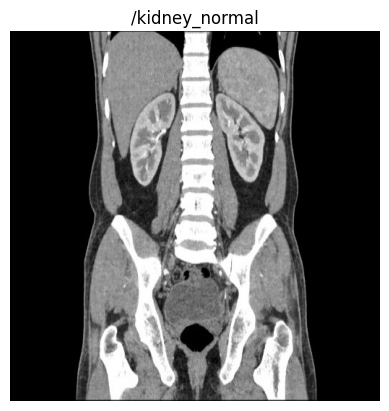

In [7]:
 
def random_image_viewer(target_dir,target_class):
    #setup target directory
    target_folder=target_dir+target_class

    #GET RANDOM IMAGE PATH 
    random_image=random.sample(os.listdir(target_folder), 1)
    print(random_image)

    #read the image and plot it using matplotlib 
    img=mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape: {img.shape}")
    
    return img


img=random_image_viewer(target_dir="train/",target_class="/kidney_normal")

In [8]:
IMG_SIZE = 224
TRAIN_DIR = 'train'
TEST_DIR = 'test'
CLASS_LABELS = os.listdir(TRAIN_DIR)

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    rescale=1./255,
                                                                    validation_split=0.2    )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    rescale=1./255      )

In [10]:
train_generator = train_datagen.flow_from_directory(    TRAIN_DIR,
                                                        target_size=(128, 128),
                                                        batch_size=32,
                                                        class_mode ='categorical',
                                                        subset='training',
                                                        shuffle=True,
                                                        classes=CLASS_LABELS    )

validation_generator = train_datagen.flow_from_directory(   TRAIN_DIR,
                                                            target_size=(128, 128),
                                                            batch_size=32,
                                                            class_mode='categorical',
                                                            subset='validation',
                                                            shuffle=True,
                                                            classes=CLASS_LABELS    )

test_generator = test_datagen.flow_from_directory(  TEST_DIR,
                                                    target_size=(128, 128, 3),
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    shuffle =False,
                                                    classes=CLASS_LABELS    )

Found 5600 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the input shape
input_shape = (128, 128, 3)

# Define the CNN model
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    batch_size=32
)


Epoch 1/3
175/175 [==============================] - 14s 78ms/step - loss: 2.1137e-05 - accuracy: 1.0000 - val_loss: 1.9988 - val_accuracy: 0.8307
Epoch 2/3
175/175 [==============================] - 14s 80ms/step - loss: 1.6297e-05 - accuracy: 1.0000 - val_loss: 2.0699 - val_accuracy: 0.8329
Epoch 3/3
175/175 [==============================] - 14s 82ms/step - loss: 1.2559e-05 - accuracy: 1.0000 - val_loss: 2.1688 - val_accuracy: 0.8336


In [15]:
import numpy as np
from sklearn.metrics import classification_report

# Load the test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

# Predict the classes for the test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

Found 3000 images belonging to 2 classes.
94/94 [==============================] - 19s 201ms/step
               precision    recall  f1-score   support

kidney_normal       1.00      0.94      0.97      1500
 kidney_tumor       0.94      1.00      0.97      1500

     accuracy                           0.97      3000
    macro avg       0.97      0.97      0.97      3000
 weighted avg       0.97      0.97      0.97      3000

